# 선형회귀 - 의료보험 비용 예측

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
import random

SEED = 42 # 변경가능

random.seed(SEED)
np.random.seed(SEED)

In [149]:
np.set_printoptions(precision=4, linewidth=200) # 소수점 네번째 수 까지만 표시

# 데이터준비

## 데이터 로딩

In [150]:
!wget "https://raw.githubusercontent.com/devdio/flyai_datasets/refs/heads/main/insurance.csv"

--2025-12-23 06:13:05--  https://raw.githubusercontent.com/devdio/flyai_datasets/refs/heads/main/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55628 (54K) [text/plain]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  54.32K  --.-KB/s    in 0.001s  

2025-12-23 06:13:05 (37.9 MB/s) - ‘insurance.csv.4’ saved [55628/55628]



In [151]:
df = pd.read_csv("/content/insurance.csv")
df.shape

(1338, 7)

In [152]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## EDA

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [154]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### 타겟값

<Axes: xlabel='charges', ylabel='Count'>

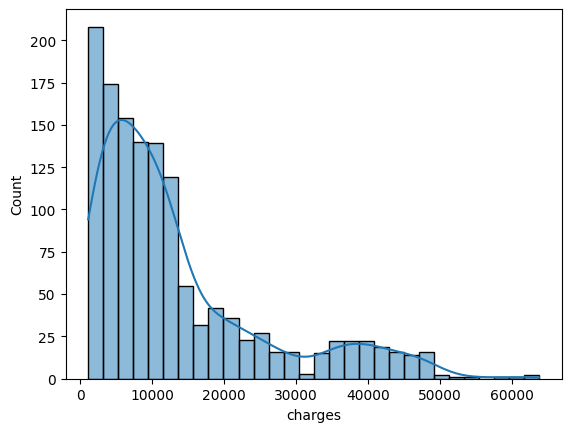

In [155]:
sns.histplot(data=df, x="charges", kde=True)
# 정규분포일때 학습이 잘됨. log취해서 정규분포 형태로 바꿔서 학습시키면 더 잘될듯.

In [156]:
df["log_charges"] = np.log(df["charges"])
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


<Axes: xlabel='log_charges', ylabel='Count'>

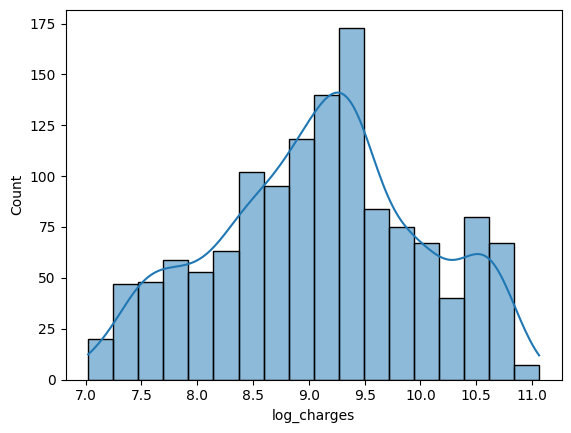

In [157]:
sns.histplot(data=df, x="log_charges", kde=True)

In [158]:
df["region"].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [159]:
# 결측치
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0
log_charges,0


<Axes: xlabel='region', ylabel='log_charges'>

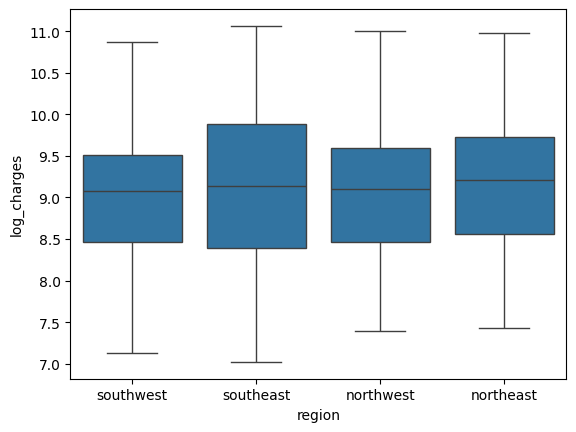

In [160]:
sns.boxplot(data=df, x="region", y="log_charges")

# 데이터 분리

In [161]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=SEED)

train.shape, test.shape

((1070, 8), (268, 8))

In [162]:
X_train = train.drop(columns=["charges","log_charges"], axis=1)
X_train.head()


,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


In [163]:
y_train = train["log_charges"]
y_train.head()

,log_charges
560,9.126289
1285,9.051892
1142,10.207953
969,9.059149
486,9.431510


# 데이터 전처리

## Ordinal Encoder

In [164]:
X_train.head(5)

,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


In [165]:
X_train["sex"].map({"female":0, "male":1}).head() # 이렇게 수동으로해도 상관없지만

,sex
560,0
1285,0
1142,0
969,0
486,0


In [166]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
categorial_columns = ["sex", "smoker"]

X_encoded = pd.DataFrame(oe.fit_transform(X_train[categorial_columns]),
                 columns=["is_sex","is_smoker"],
                 index=X_train.index)


In [167]:
X_train_e = pd.concat([X_train, X_encoded],axis=1)

In [168]:
X_train_e.head()

,age,sex,bmi,children,smoker,region,is_sex,is_smoker
560,46,female,19.95,2,no,northwest,0.0,0.0
1285,47,female,24.32,0,no,northeast,0.0,0.0
1142,52,female,24.86,0,no,southeast,0.0,0.0
969,39,female,34.32,5,no,southeast,0.0,0.0
486,54,female,21.47,3,no,northwest,0.0,0.0


## One-hot Encoder

In [169]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

onehot_columns = ["region"]

ohe.fit_transform(X_train[onehot_columns])


array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [170]:
X_encoded = pd.DataFrame(data=ohe.fit_transform(X_train_e[onehot_columns]),
                         columns=ohe.get_feature_names_out(),
                         index=X_train_e.index)

X_encoded

,region_northeast,region_northwest,region_southeast,region_southwest
560,0.0,1.0,0.0,0.0
1285,1.0,0.0,0.0,0.0
1142,0.0,0.0,1.0,0.0
969,0.0,0.0,1.0,0.0
486,0.0,1.0,0.0,0.0
...,...,...,...,...
1095,1.0,0.0,0.0,0.0
1130,0.0,0.0,1.0,0.0
1294,1.0,0.0,0.0,0.0
860,0.0,0.0,0.0,1.0


In [171]:
X_train_e = pd.concat([X_train_e, X_encoded],axis=1)

X_train_e.head()

,age,sex,bmi,children,smoker,region,is_sex,is_smoker,region_northeast,region_northwest,region_southeast,region_southwest
560,46,female,19.95,2,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0
1285,47,female,24.32,0,no,northeast,0.0,0.0,1.0,0.0,0.0,0.0
1142,52,female,24.86,0,no,southeast,0.0,0.0,0.0,0.0,1.0,0.0
969,39,female,34.32,5,no,southeast,0.0,0.0,0.0,0.0,1.0,0.0
486,54,female,21.47,3,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0


In [172]:
X_train_e = X_train_e.drop(["sex","smoker","region"],axis=1)

X_train_e.head()

,age,bmi,children,is_sex,is_smoker,region_northeast,region_northwest,region_southeast,region_southwest
560,46,19.95,2,0.0,0.0,0.0,1.0,0.0,0.0
1285,47,24.32,0,0.0,0.0,1.0,0.0,0.0,0.0
1142,52,24.86,0,0.0,0.0,0.0,0.0,1.0,0.0
969,39,34.32,5,0.0,0.0,0.0,0.0,1.0,0.0
486,54,21.47,3,0.0,0.0,0.0,1.0,0.0,0.0


## 스케일링
- X
- y

In [173]:
from sklearn.preprocessing import StandardScaler

xss = StandardScaler()

X_train_s = xss.fit_transform(X_train_e) # 스케일러 함수 쓰면 데이터 타입이 numpy로 바뀜
X_train_s[:10]


array([[ 0.4722, -1.7565,  0.7343, -1.0246, -0.5087, -0.5766,  1.7832, -0.5997, -0.5723],
       [ 0.5433, -1.0331, -0.9112, -1.0246, -0.5087,  1.7342, -0.5608, -0.5997, -0.5723],
       [ 0.8987, -0.9437, -0.9112, -1.0246, -0.5087, -0.5766, -0.5608,  1.6676, -0.5723],
       [-0.0254,  0.6224,  3.2026, -1.0246, -0.5087, -0.5766, -0.5608,  1.6676, -0.5723],
       [ 1.0409, -1.5049,  1.5571, -1.0246, -0.5087, -0.5766,  1.7832, -0.5997, -0.5723],
       [ 1.6807,  1.8061, -0.9112,  0.976 , -0.5087, -0.5766, -0.5608,  1.6676, -0.5723],
       [-1.2338, -1.0364, -0.9112, -1.0246, -0.5087, -0.5766, -0.5608, -0.5997,  1.7473],
       [-1.5182, -1.4892, -0.9112,  0.976 ,  1.9656,  1.7342, -0.5608, -0.5997, -0.5723],
       [ 0.0457,  1.7663, -0.0884,  0.976 , -0.5087,  1.7342, -0.5608, -0.5997, -0.5723],
       [-0.1676,  0.6025, -0.0884,  0.976 ,  1.9656,  1.7342, -0.5608, -0.5997, -0.5723]])

In [174]:
yss = StandardScaler()
y_train_s = yss.fit_transform(y_train.to_numpy().reshape(-1,1)) # 함수에서 2차원 이상만 처리할 수 있도록 함. np로 2차원으로 바꿔주기
y_train_s = y_train_s.reshape(-1)
y_train_s[:10]

array([ 0.0142, -0.0674,  1.2013, -0.0595,  0.3492,  0.4281, -1.5802,  0.4558, -0.3479,  1.6015])

## 최종 학습 데이터

In [175]:
type(X_train_s), type(y_train_s), X_train_s.shape, y_train_s.shape

(numpy.ndarray, numpy.ndarray, (1070, 9), (1070,))

# 모델 (베이스라인)
- 학습

In [176]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_s, y_train_s)

LinearRegression()

In [177]:
model.coef_, model.intercept_ # 절편

(array([ 0.5287,  0.0902,  0.1233, -0.0408,  0.6882,  0.0377,  0.0108, -0.0274, -0.0204]),
 np.float64(-1.2052141003749041e-15))

# 테스트

- X, y 분리
- 인코딩 (Ordinal Encoder, One-hot Encoder)
- 스케일링

In [178]:
test.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
764,45,female,25.175,2,no,northeast,9095.06825,9.115488
887,36,female,30.020,0,no,northwest,5272.17580,8.570198
890,64,female,26.885,0,yes,northwest,29330.98315,10.286400
1293,46,male,25.745,3,no,northwest,9301.89355,9.137973
259,19,male,31.920,0,yes,northwest,33750.29180,10.426744


In [179]:
X_test = test.drop(["charges","log_charges"], axis=1) # 쓸모없는 컬럼과 타겟컬럼 빼기
y_test = test["log_charges"]

X_test.shape, y_test.shape

((268, 6), (268,))

In [180]:
# 결측치
X_test.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0


## Ordinal Encoder

In [181]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
categorial_columns = ["sex", "smoker"]

X_test_encoded = pd.DataFrame(oe.fit_transform(X_test[categorial_columns]),
                 columns=["is_sex","is_smoker"],
                 index=X_test.index)


In [182]:
X_test_e = pd.concat([X_test, X_test_encoded],axis=1)

In [183]:
X_test_e.head()

,age,sex,bmi,children,smoker,region,is_sex,is_smoker
764,45,female,25.175,2,no,northeast,0.0,0.0
887,36,female,30.020,0,no,northwest,0.0,0.0
890,64,female,26.885,0,yes,northwest,0.0,1.0
1293,46,male,25.745,3,no,northwest,1.0,0.0
259,19,male,31.920,0,yes,northwest,1.0,1.0


## One-hot Encoder

In [184]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

onehot_columns = ["region"]

ohe.fit_transform(X_test[onehot_columns])


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [185]:
X_test_encoded = pd.DataFrame(data=ohe.fit_transform(X_test_e[onehot_columns]),
                         columns=ohe.get_feature_names_out(),
                         index=X_test_e.index)

X_test_encoded

,region_northeast,region_northwest,region_southeast,region_southwest
764,1.0,0.0,0.0,0.0
887,0.0,1.0,0.0,0.0
890,0.0,1.0,0.0,0.0
1293,0.0,1.0,0.0,0.0
259,0.0,1.0,0.0,0.0
...,...,...,...,...
109,0.0,0.0,1.0,0.0
575,0.0,1.0,0.0,0.0
535,1.0,0.0,0.0,0.0
543,0.0,0.0,1.0,0.0


In [186]:
X_test_e = pd.concat([X_test_e, X_test_encoded],axis=1)

X_test_e.head()

,age,sex,bmi,children,smoker,region,is_sex,is_smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,45,female,25.175,2,no,northeast,0.0,0.0,1.0,0.0,0.0,0.0
887,36,female,30.020,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0
890,64,female,26.885,0,yes,northwest,0.0,1.0,0.0,1.0,0.0,0.0
1293,46,male,25.745,3,no,northwest,1.0,0.0,0.0,1.0,0.0,0.0
259,19,male,31.920,0,yes,northwest,1.0,1.0,0.0,1.0,0.0,0.0


In [187]:
X_test_e = X_test_e.drop(["sex","smoker","region"],axis=1)

X_test_e.head()

,age,bmi,children,is_sex,is_smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,45,25.175,2,0.0,0.0,1.0,0.0,0.0,0.0
887,36,30.020,0,0.0,0.0,0.0,1.0,0.0,0.0
890,64,26.885,0,0.0,1.0,0.0,1.0,0.0,0.0
1293,46,25.745,3,1.0,0.0,0.0,1.0,0.0,0.0
259,19,31.920,0,1.0,1.0,0.0,1.0,0.0,0.0


## 스케일링

In [189]:
X_test_s = xss.transform(X_test_e) # fit_transform 사용X-> 그럼 테스트 데이터에서 다시 mean, std 계산

In [190]:
y_test_s = yss.transform(y_test.to_numpy().reshape(-1,1)).reshape(-1)
y_test_s[:10]

array([ 0.0024, -0.5961,  1.2874,  0.0271,  1.4415, -0.7611, -1.5973,  0.4921, -0.9751,  0.1351])

## 최종 테스트 데이터

In [197]:
type(X_test_s), type(y_test_s), X_test_s.shape, y_test_s.shape

(numpy.ndarray, numpy.ndarray, (268, 9), (268,))

In [198]:
y_pred_s = model.predict(X_test_s)
y_pred_s[:10]

array([ 1.4044e-03, -5.2937e-01,  2.1792e+00,  5.4448e-03,  4.8143e-01, -4.6503e-01, -1.2803e+00,  5.5907e-01, -9.5813e-01,  1.6215e-01])

In [199]:
y_test_s[:10]

array([ 0.0024, -0.5961,  1.2874,  0.0271,  1.4415, -0.7611, -1.5973,  0.4921, -0.9751,  0.1351])

In [200]:
# 스케일링한거 원본으로 돌리기
y_pred_log = yss.inverse_transform(y_pred_s.reshape(-1,1)).reshape(-1)
y_pred_log[:10]

array([ 9.1146,  8.631 , 11.0989,  9.1183,  9.552 ,  8.6896,  7.9467,  9.6227,  8.2403,  9.2611])

In [201]:
y_test.to_numpy()[:10]

array([ 9.1155,  8.5702, 10.2864,  9.138 , 10.4267,  8.4199,  7.6579,  9.5617,  8.2249,  9.2364])

# 평가

In [202]:
from sklearn.metrics import mean_squared_error, r2_score

def print_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  r2  = r2_score(y_true, y_pred)
  print(f"MSE : {mse}, R2 : {r2}")

print_metrics(y_test, y_pred_log)

MSE : 0.17557416396791647, R2 : 0.8047311493462987


In [205]:
from sklearn.metrics import mean_squared_error, r2_score

def print_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  r2  = r2_score(y_true, y_pred)
  print(f"MSE : {mse}, R2 : {r2}")

print_metrics(np.exp(y_test), np.exp(y_pred_log)) ## 처음에 log취했던걸 다시 없애주기

MSE : 61079027.74116516, R2 : 0.606573096254885


# Ridge

In [221]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_s, y_train_s)

Ridge()

In [222]:
y_pred_s = ridge.predict(X_test_s)
y_pred_log = yss.inverse_transform(y_pred_s.reshape(-1,1)).reshape(-1)

In [223]:
print_metrics(y_test, y_pred_log)

MSE : 0.1756149249562156, R2 : 0.8046858160742683


# Lasso

In [224]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train_s, y_train_s)

Lasso()

In [225]:
y_pred_s = lasso.predict(X_test_s)
y_pred_log = yss.inverse_transform(y_pred_s.reshape(-1,1)).reshape(-1)

In [226]:
print_metrics(y_test, y_pred_log)

MSE : 0.9045001646096238, R2 : -0.005960692438094828
